In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
library(GGally)
options(repr.plot.width=20, repr.plot.height=8)


Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
# set seed
set.seed(3456) 
# retrieve data
dataUrl <- "https://raw.githubusercontent.com/rjarvi/dsci_100_group_21/main/heart%2Bdisease/processed.cleveland.data"
colNames <- c("age","sex","cp","restingbps","chollevels","fbs","restecg","maxheartrate","exang","stdepress", "slope", "ca", "thal", "diagnosis")
rawdata <- read.csv(url(dataUrl), header=FALSE, col.names = colNames)

In [3]:
#data cleaning and modification
heartdf <- rawdata |> select(age, restingbps, chollevels, maxheartrate, stdepress, diagnosis)
heartdf <- replace(heartdf, heartdf == "?", NA)
heartdf <- mutate(heartdf, diagnosis = ifelse(diagnosis >= 1, 1, diagnosis))
heartdf <- heartdf |>
    mutate(diagnosis = factor(ifelse(diagnosis == 0, "No", "Yes"), levels = c("No", "Yes")))

heart_split <- initial_split(heartdf, prop = 0.75, strata = diagnosis)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)
heart_train_no_class <- select(heart_train, age, restingbps, chollevels, maxheartrate, stdepress)

In [4]:
diagnosis_summary <- heart_train |>
    group_by(diagnosis) |>
    summarize(count = n())
diagnosis_summary

diagnosis,count
<fct>,<int>
No,123
Yes,104


In [5]:
summary_stats <- heart_train_no_class |>
    sapply(function(x) {
    if(is.numeric(x)) {
        c(
            mean = round(mean(x, na.rm = TRUE), 2),
            sd = round(sd(x, na.rm = TRUE), 2),
            min = round(min(x, na.rm = TRUE), 1),
            max = round(max(x, na.rm = TRUE), 1),
            empty_cells = as.integer(sum(is.na(x))),
            entry_count = as.integer(sum(!is.na(x)))
        )
        } else {
            NULL
        }
})

summary_df <- as.data.frame(summary_stats)
summary_df

,age,restingbps,chollevels,maxheartrate,stdepress
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
mean,55.00,132.27,249.82,149.48,1.02
sd,9.18,18.69,52.80,22.52,1.14
min,29.00,94.00,131.00,88.00,0.00
max,77.00,200.00,564.00,202.00,6.20
empty_cells,0.00,0.00,0.00,0.00,0.00
entry_count,227.00,227.00,227.00,227.00,227.00


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


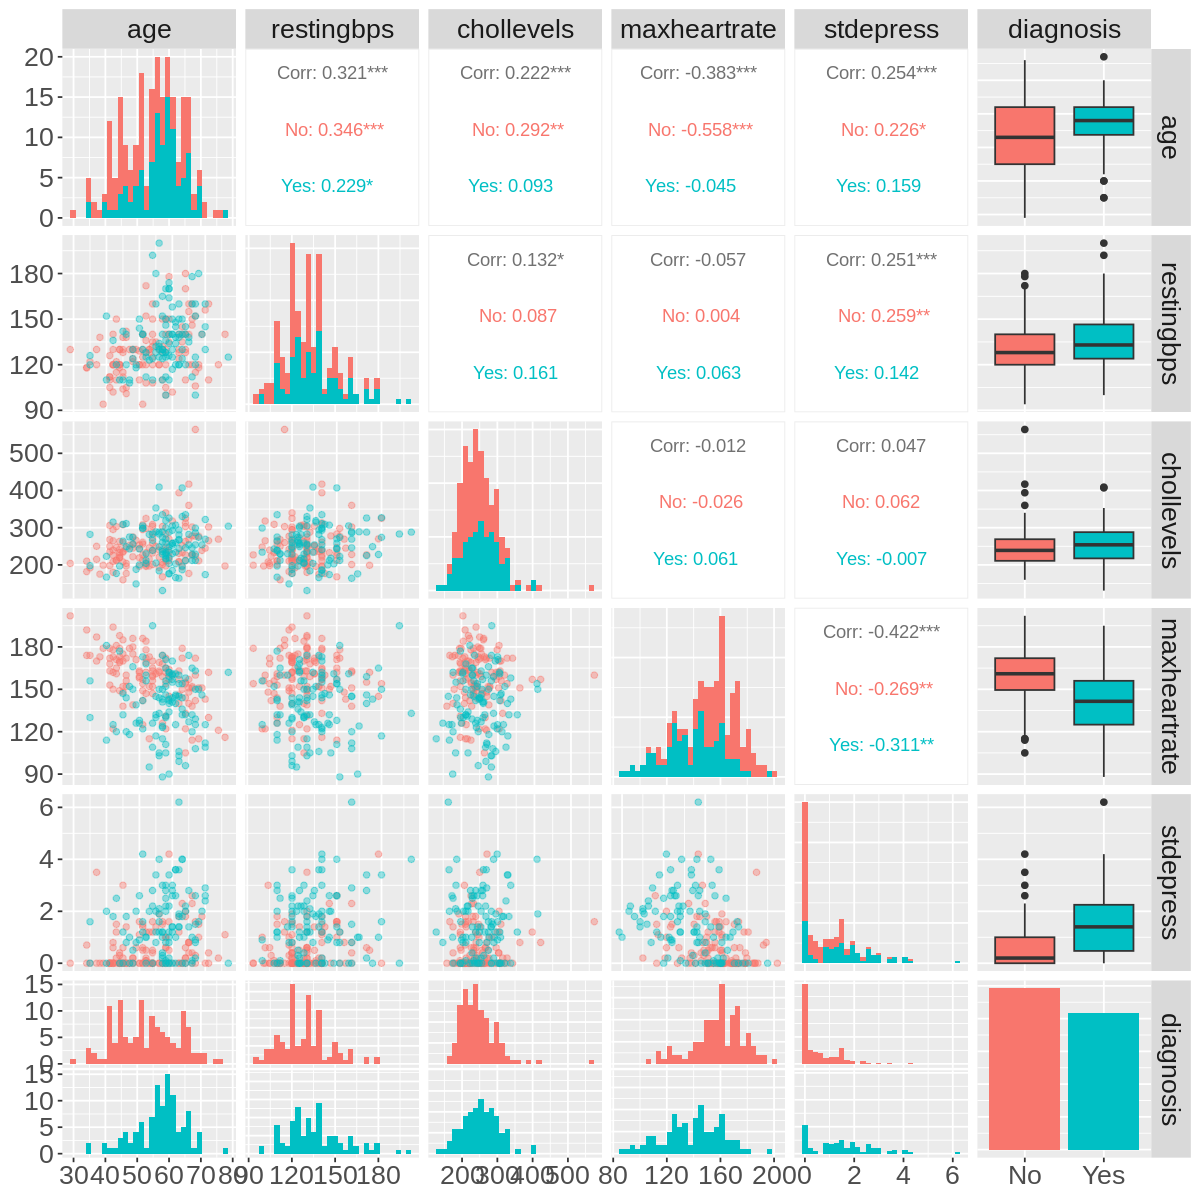

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10) 

heart_pairplot <- heart_train |> 
    ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.4)),
        diag = list(continuous = "barDiag"),
        mapping = aes(color = diagnosis)
    ) +
    theme(text = element_text(size = 20))
heart_pairplot


TODO add analyis, but to start:
Resting heart rate and cholesterol levels do not seem to have strong correlation with heart disease
ST depression mb weakly positively correlated
max heart rate moderately weakly correlated

In [ ]:
set.seed(1234)
#recipie stuff
knn_heart_recipe <- recipe(diagnosis ~ age + restingbps + chollevels + maxheartrate +stdepress, data = heart_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())


knn_heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 10, strata = diagnosis)

knn_results <- workflow() |>
      add_recipe(knn_heart_recipe) |>
      add_model(knn_heart_spec) |>
      fit(data = heart_train) |>
      tune_grid(resamples = heart_vfold, grid = 20) |>
      collect_metrics()

accuracies <- knn_results |> 
      filter(.metric == "accuracy")

Warning message:
“tune samples were requested but there were 227 rows in the data. 222 will be used.”


In [ ]:
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 20, by = 1)) +
      scale_y_continuous(limits = c(0.4, 1.0))

accuracy_versus_k

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7368421
kap,binary,0.4681596


          Truth
Prediction No Yes
       No  32  11
       Yes  9  24

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


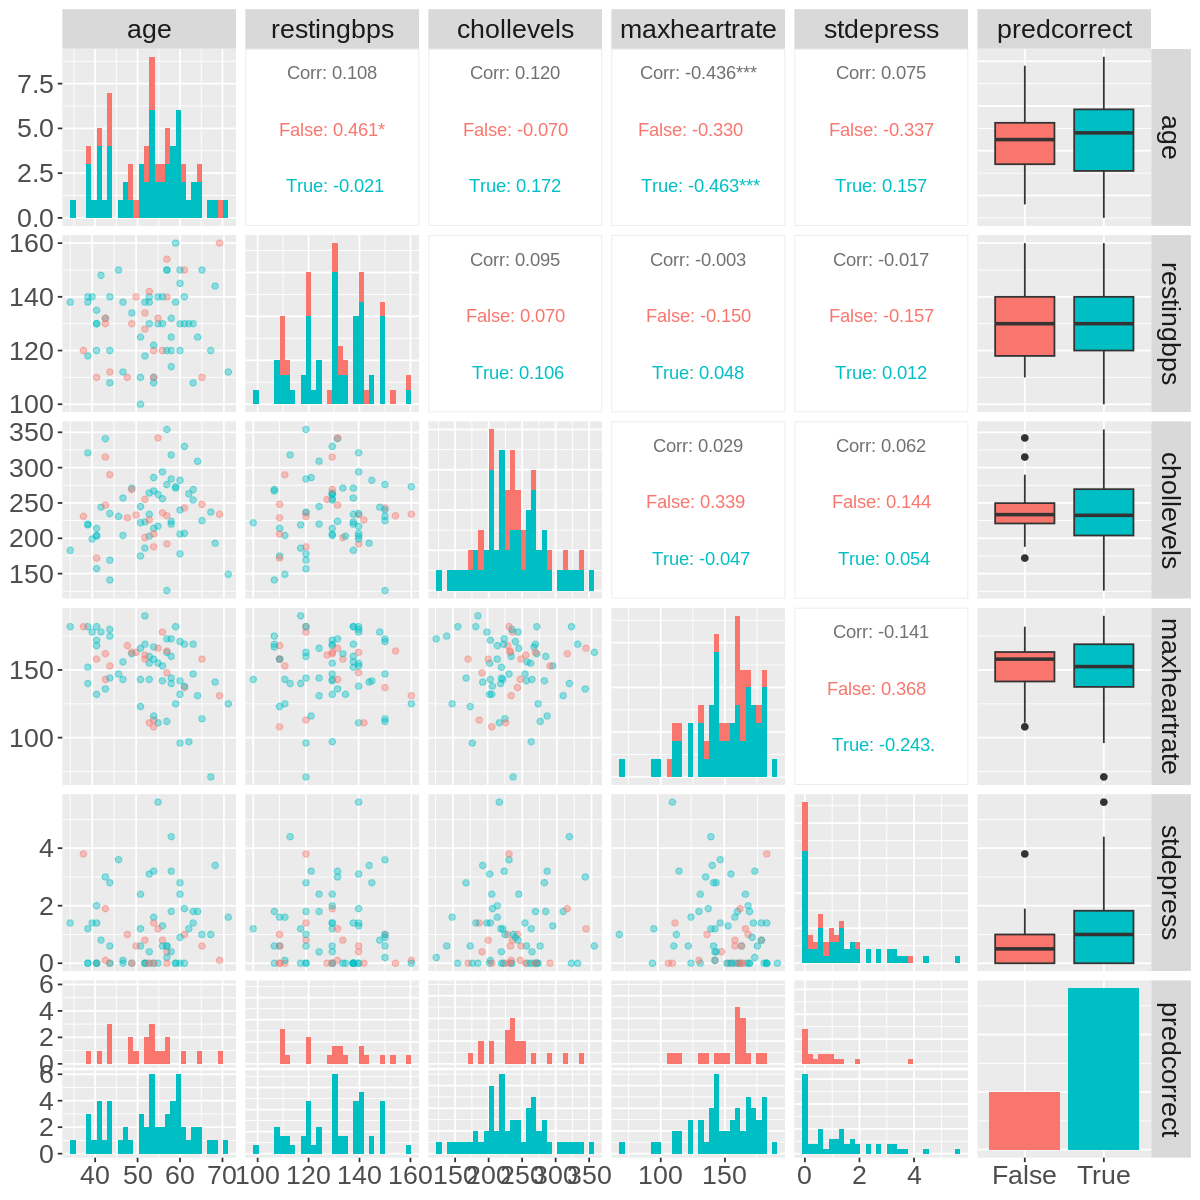

In [10]:
knn_final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
      set_engine("kknn") |>
      set_mode("classification")

heart_final_fit <- workflow() |>
    add_recipe(knn_heart_recipe) |>
    add_model(knn_final_spec) |>
    fit(data = heart_train)


heart_test_predictions <- predict(heart_final_fit , heart_test) |>
      bind_cols(heart_test)

heart_test_predictions <- heart_test_predictions |> mutate(predresult = case_when(
    .pred_class == "Yes" & diagnosis == "Yes" ~ "TP",
    .pred_class == "No" & diagnosis == "No" ~ "TN",
    .pred_class == "Yes" & diagnosis == "No" ~ "FP",
    .pred_class == "No" & diagnosis == "Yes" ~ "FN",
    TRUE ~ "Other"
  ))

heart_test_predictions <- heart_test_predictions |> mutate(predcorrect = case_when(
    .pred_class == "Yes" & diagnosis == "Yes" ~ "True",
    .pred_class == "No" & diagnosis == "No" ~ "True",
    .pred_class == "Yes" & diagnosis == "No" ~ "False",
    .pred_class == "No" & diagnosis == "Yes" ~ "False",
    TRUE ~ "Other"
  ))

heart_prediction_accuracy <- heart_test_predictions |>
        metrics(truth = diagnosis, estimate = .pred_class)             

heart_prediction_accuracy

heart_mat <- heart_test_predictions |> 
      conf_mat(truth = diagnosis, estimate = .pred_class)

heart_mat

# confusion_matrix_plot1 <- ggplot(heart_test_predictions, aes(x = age, y = maxheartrate)) +
#     geom_point(aes(colour = predresult, shape = predresult)) +
#     labs(x = "Age", y = "Max Heart Rate (BPS)", colour = "Confusion Matrix Category", shape = "Confusion Matrix Category")
# confusion_matrix_plot1

# confusion_matrix_plot2 <- ggplot(heart_test_predictions, aes(x = age, y = maxheartrate)) +
#     geom_point(aes(colour = predcorrect, shape = predcorrect)) +
#     labs(x = "Age", y = "Max Heart Rate (BPS)", colour = "Confusion Matrix Category", shape = "Confusion Matrix Category")
# confusion_matrix_plot2


heart_confusion_pairplot <- heart_test_predictions|> 
    select(age, restingbps, chollevels, maxheartrate, stdepress, predcorrect) |>
    ggpairs(
        lower = list(continuous = wrap('points', alpha = 0.4)),
        diag = list(continuous = "barDiag"),
        mapping = aes(color = predcorrect)
    ) +
    theme(text = element_text(size = 20))
heart_confusion_pairplot


#TODO: add more plots here - compare with rest of variables?

Things to do:
written analysis of confusion matrix 
